# ARIMA

Autoregressive Integrated Moving Average `ARIMA` is a way to model time series data based its own past values.

- p: order of AR term; number of lags to be used as predictors; used to remove autocorrelation from stationarized time series
- q: order of MA term; number of lagged forecast errors that should be used; used to remove autocorrelation from stationarized time series
- d: minimum number of differencing required to make the time series stationary (a time series is stationary when the distribution of values is time-invariant or does not depend on time)

The Autoregressive `AR` model is given as follows.

$Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_p Y_{t-p} + e_1$

The Moving Average `MA` model is given as follows.

$Y_t = \alpha + e_t + \phi_1 e_{t-1} + \phi_2 e_{t-2} + \ldots + \phi_q e_{t-q}$

The errors $e_t, e_{t-1}, \ldots, e_{t-q}$ are the errors from the following equations.

- $Y_t = \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_0 Y_0 + e_t$
- $Y_{t-1} = \beta_1 Y_{t-2} + \beta_2 Y_{t-3} + \ldots + \beta_0 Y_0 + e_{t-1}$
- $Y_{t-q} = \beta_1 Y_{t-q-1} + \beta_2 Y_{t-q-2} + \ldots + \beta_0 Y_0 + e_{t-q}$

When you combine the AR and MA models and difference the time series at least once, you get the ARIMA model defined as follows.

$Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_p Y_{t-p} + e_t + \phi_1 e_{t-1} + \phi_2 e_{t-2} + \ldots + \phi_q e_{t-q}$

In [118]:
import numpy as np
import pandas as pd

np.random.seed(37)

N = 1_000
# s = pd.Series(np.random.normal(0, 1, N))
s = pd.Series(np.sin(np.arange(100)))

In [119]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs

def plot_data(s):
    adf_stat, p_val, *_ = adfuller(s)
    n_diffs = ndiffs(s)
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 5.5))
    ax = np.ravel(ax)

    _ = s.plot(ax=ax[0])
    _ = s.plot(kind='kde', ax=ax[1])
    _ = plot_acf(
        s, 
        title=f'Autocorrelation, MA(q)', 
        ax=ax[2]
    )
    _ = plot_pacf(s, method='ywm', title='Partial Autocorrelation, AR(p)', ax=ax[3])
    
    ax[0].set_title(f'Time Series\nADF={adf_stat:.2f}, p-val={p_val:.2f}, d={n_diffs}')
    ax[1].set_title('Distribution')
    
    plt.tight_layout()

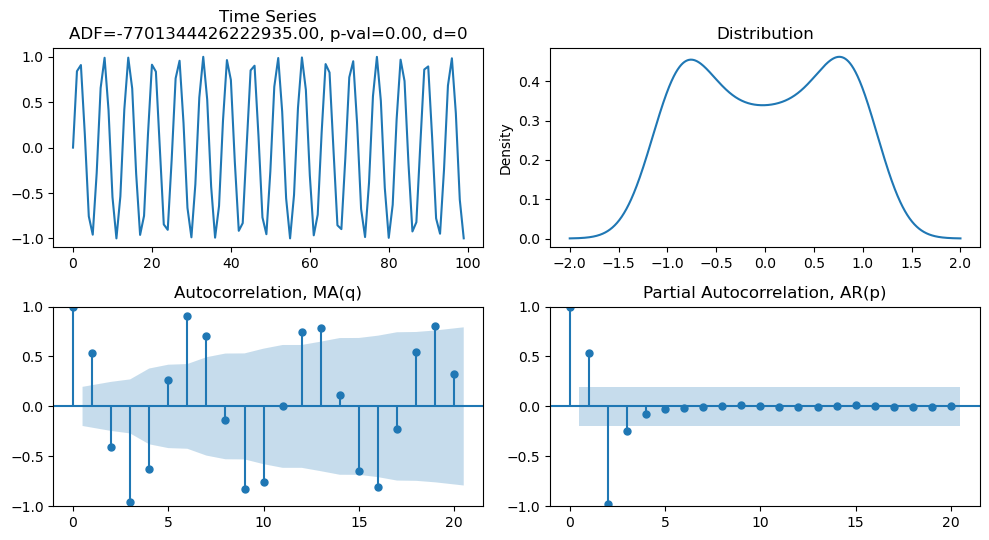

In [120]:
plot_data(s)

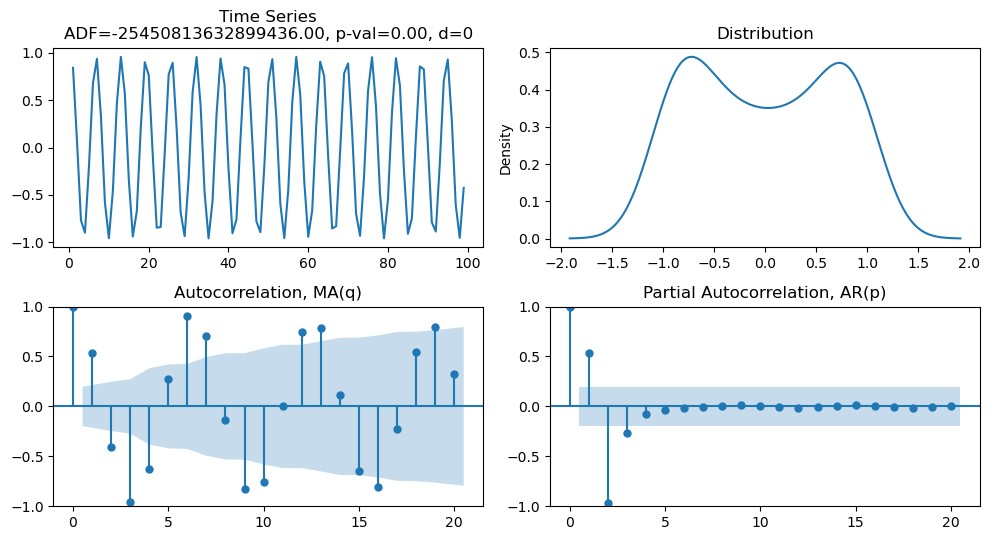

In [121]:
plot_data(s.diff().dropna())

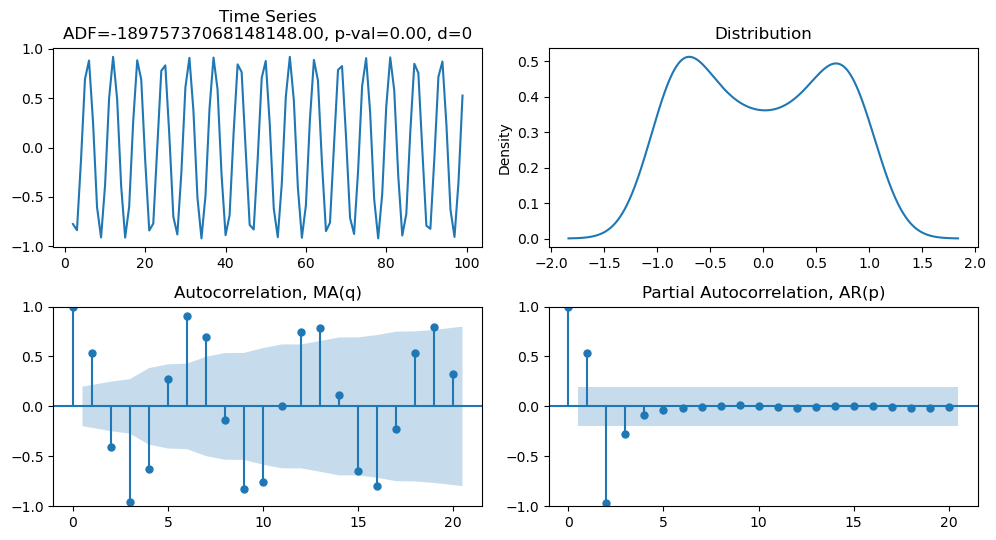

In [122]:
plot_data(s.diff().diff().dropna())

In [135]:
from statsmodels.tsa.arima.model import ARIMA

p = 2 # AR
q = 2 # MA
d = 0 

model = ARIMA(s, order=(p, d, q))
fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 591.505
Date:                Thu, 27 Oct 2022   AIC                          -1171.010
Time:                        03:37:24   BIC                          -1155.379
Sample:                             0   HQIC                         -1164.684
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.926e-06      0.003     -0.002      0.998      -0.005       0.005
ar.L1          1.0806      0.004    248.428      0.000       1.072       1.089
ar.L2         -1.0000   5.45e-06  -1.83e+05      0.000      -1.000      -1.000
ma.L1       2.396e-05   1.25e-07    191.431      0.000    2.37e-05    2.42e-05
ma.L2       2.194e-05    5.4e-08    405.911      0.000    2.18e-05     2.2e-05
sigma2      3.544e-07    7.8e-08      4.541      0.000    2.01e-07    5.07e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             39122.90
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             9.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        97.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+26. Standard errors may be unstable.
"""

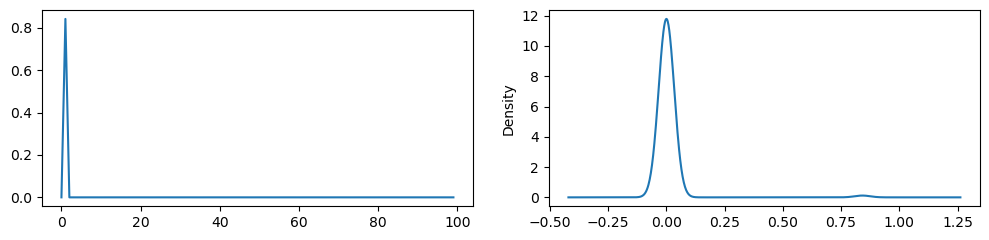

In [125]:
r = pd.Series(fit.resid)

fig, ax = plt.subplots(1, 2, figsize=(10, 2.5))

r.plot(ax=ax[0])
r.plot(kind='kde', ax=ax[1])

plt.tight_layout()

<AxesSubplot:>

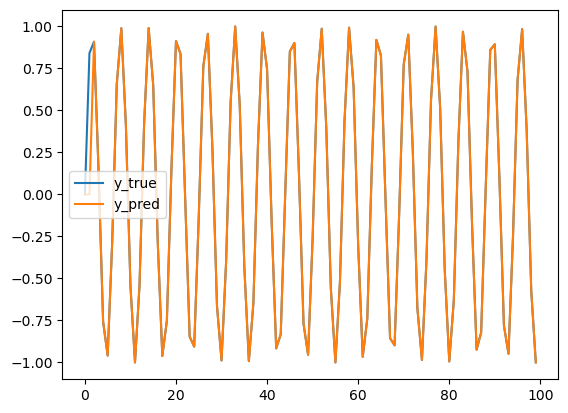

In [126]:
pd.DataFrame({'y_true': s, 'y_pred': fit.predict(dynamic=False)}).plot()